**GOAL OF THE NOTEBOOK:** Big assumption we are making - state transition table. This is only possible when the problem is deterministic and we have the complete model of the environment.

A lot of times, we don’t have the state transition table available as we often don’t have discrete states and hence it is generally hard to figure out which action causes which state transition.


**So, the idea is not to use the state transition table and instead associate `Quality` values to the actions themselves and take the approporiate action or random action based on epsilon-greedy strategy to converge faster.**

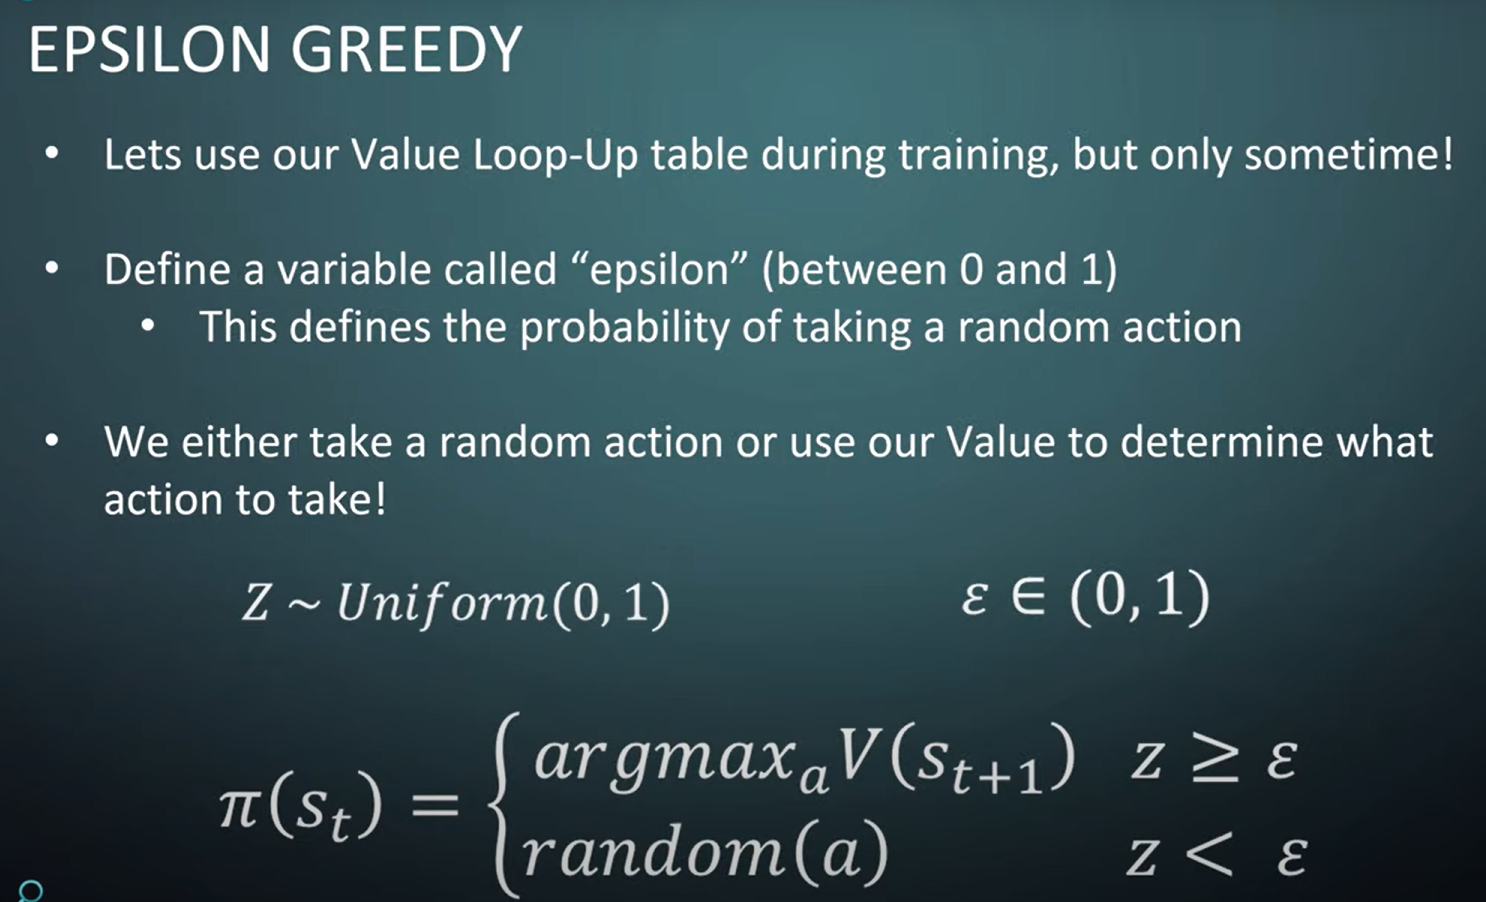

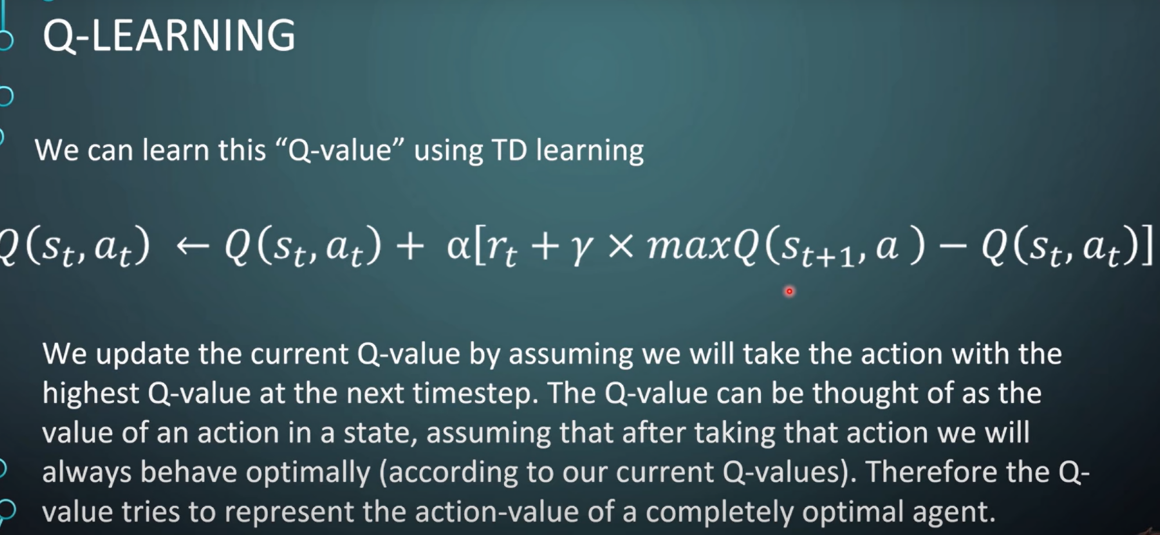

We are making the rewards of certain grid cells negative to establish that the agent gets penalized to go into those grid cells and it should avoid them.

## Imports

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

## Reward function definition

In [ ]:
rewards = np.zeros(16)
rewards[3] = 10 # HIGH POSITIVE REWARD
rewards[2] = -1 # NEGATIVE REWARDS
rewards[11] = -1
rewards[10] = -1


terminal_state = 3
# state_values = np.zeros(16) We don't need state values any more

Q_values = np.zeros((16,4)) # Initializing Q-values
# This is the Q-value - Action table. So, we are mapping ourselves, which action causes which transition using this table.
# Slowly, we understand these and then navigate through the state action pairs that are associated with higher Q-values.
# No of possible states = 16. No of possible actions = 4. So this table is of the shape (16,4)

alpha = 0.01
epsilon = 0.4 # EPSILON GREEDY STRATEGY

score_log = []

In [ ]:
rewards

array([ 0.,  0., -1., 10.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0.,
        0.,  0.,  0.])

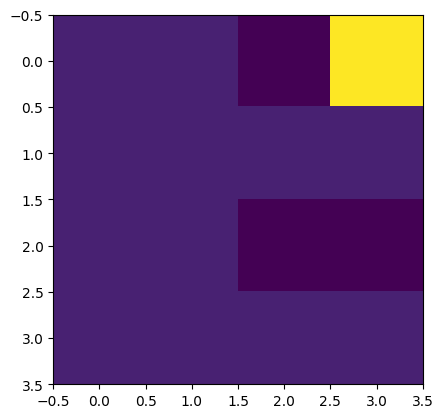

In [ ]:
plt.imshow(rewards.reshape(4,4))

## State transition table

The following is our state transition table. We have 16 possible states in total from 0 to 15 and this table respresents how all the possible actions ie., Four actions 1 -> up, 2 -> right, 3 -> down, 4-> left affect the state transitions.

We are still having the state transition table for us to understand how the environment is being modelled. However, the agent policy in our code doesn't use this state transition table in any step to decide the action it is going to take.

In [ ]:
file_path = "/content/drive/MyDrive/Colab_Notebooks/Reinforcement_Learning_notebooks/Grid_world_example/state_transitions.csv"
state_transition_table = np.genfromtxt(file_path, delimiter=",").astype(int)

In [ ]:
state_transition_table

array([[ 0,  1,  4,  0],
       [ 1,  2,  5,  0],
       [ 2,  3,  6,  1],
       [ 3,  3,  7,  2],
       [ 0,  5,  8,  4],
       [ 1,  6,  9,  4],
       [ 2,  7, 10,  5],
       [ 3,  7, 11,  6],
       [ 4,  9, 12,  8],
       [ 5, 10, 13,  8],
       [ 6, 11, 14,  9],
       [ 7, 11, 15, 10],
       [ 8, 13, 12, 12],
       [ 9, 14, 13, 12],
       [10, 15, 14, 13],
       [11, 15, 15, 14]])

In [ ]:
state_transition_table[0]

array([0, 1, 4, 0])

## Computing Q-values

We can see that in time-difference method, we don't need to compute the discounted rewards at all as we will not need all the returns of the entire trajectory.

This method involves taking state values from the future time steps and estimating values close to the average return values from the future time step.

In [ ]:
def Q_update(next_Q_values, Q_values, actions, rewards, states):
    gamma = 0.99
    next_Q_values = next_Q_values
    new_Q_values = np.zeros((16,4)) + Q_values # Making a copy of current Q-values

    for i in reversed(range(len(rewards))): # From last reward to first reward # And we don't know the values corresponding to the next state, so we estimate
        new_Q_values[states[i], actions[i]] = Q_values[states[i], actions[i]] + \
        alpha * (rewards[i] + gamma * next_Q_values - Q_values[states[i], actions[i]]) # \ is just a  line continuity character

        next_Q_values = np.max(Q_values[states[i],:]) # next_Q_values are achieved by taking the action with maximum of Q_value corresponding to it.
        # : gives the Q-values for all the actions and we take the action with the max Q-value

    return new_Q_values

## Test agent (single trajectory)

test_agent() describes a single trajectory that happens during test time.

The entire work flow would be:
1. Have a reward function
2. Training: Set multiple trajectories and give returns values to every single trajectory. Also assign values to states based on the average values of rewards in each trajectory.
3. Test time: Now, we have values of all the states and we just traverse our test agent by selecting the next state with the highest value from the state transition matrix.

In [ ]:
def test_agent():
    state = 12 #  Starting with Initial state
    done = False
    steps = 0
    total_rewards = 0
    states_log = []
    while (not(state == terminal_state)) and steps<30:
        states_log.append(state) # log the current state
        action = np.argmax(Q_values[state]) # Choose the action has highest Q-value
        state = state_transition_table[state, action] # Updating state based on the action taken
        total_rewards += rewards[state]
        steps += 1
    states_log.append(state)
    return total_rewards, states_log # returns total rewards collected along the trajectory and a log of states and their transitions

## Training loop over multiple trajectories

We get returns grids for every single trajectory. A return grid is nothing but the return value of every cell in one trajectory. If we haven't touched that particular cell in the trajectory, the return grid's corresponding value to the respective cell would be 0.

In [ ]:
number_of_trajectories = 1000

for _ in range(number_of_trajectories):
    state = 12 # Starting with the initial state
    state_log = []
    reward_log = []
    action_log = []

    done = False
    steps = 0

    # This while logic to finish the current trajectory from the initial position to the goal state
    while (not(state == terminal_state)) and steps<30:
        z = random.random() # Generates a random value between 0 and 1
        if z >=epsilon: # If random value is greater than epsilon -> EXPLOITATION ie., choosing next state with max value
            action = np.argmax(Q_values[state])
        else:
            action = random.randint(0,3) # else -> EXPLORATION ie., random action
        state_log.append(state)
        action_log.append(action)

        state = state_transition_table[state, action]
        reward_log.append(rewards[state])

        steps += 1

    next_Q_values = np.max(Q_values[state])

    Q_values = Q_update(next_Q_values, Q_values, action_log, reward_log, state_log)

    score_log.append(test_agent()[0]) # score is the reward that the test agent gets in the trajectory, which is nothing but cumulative rewards across the trajectory.

In [ ]:
state_log # These are the state values at the respective time steps in the final trajectory

[12, 12, 8, 12, 8, 4, 5, 6, 10, 6, 7]

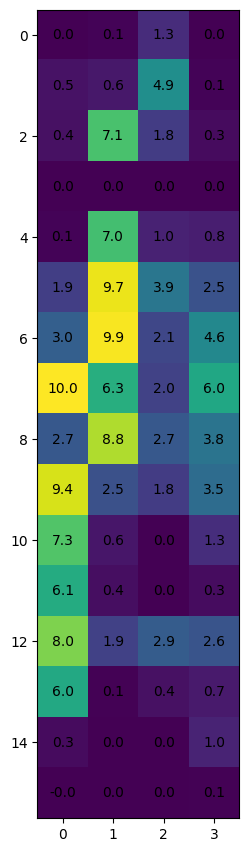

In [ ]:
fig, ax1 = plt.subplots(1)
fig.set_size_inches(18.5, 10.5)
ax1.imshow(Q_values)

for (j,i), label in np.ndenumerate(Q_values.round(1)):
    ax1.text(i,j,label,ha='center',va='center')

Every row here represents different state and every action represents different action.

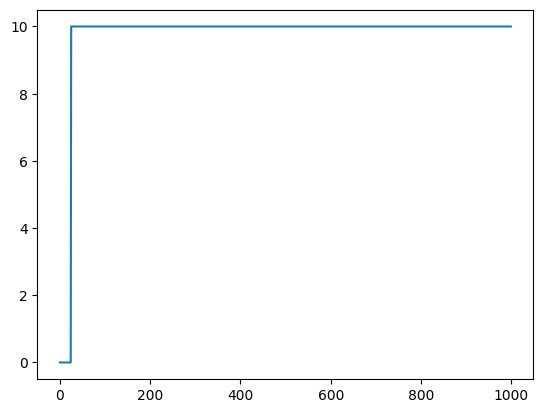

In [ ]:
plt.plot(score_log)

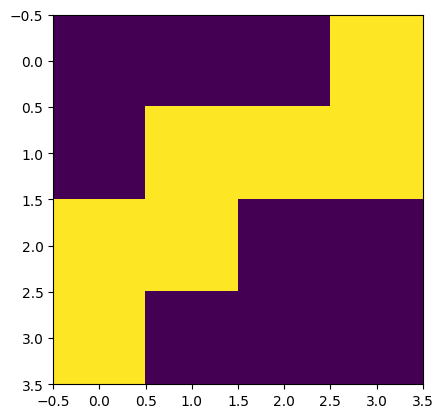

In [ ]:
_, state_log = test_agent() # state_log stores the states visited by the test_agent()
state_view = np.zeros(16) # Initializing a state_view array to view the states visited by the test agent
state_view[state_log] = 1 # Setting the value of the states visited by the test agent as 1
plt.imshow(state_view.reshape(4,4))

So, as we can see that the Q-learning algorithm is not using the state transition table to take the respective action.

So, we can take some observations from the world like sensor data and discretize into a couple of states. We don't need to have a complete understanding of actions and their respective state transitions. We can use this method to solve the problem.

When we use `Deep Learning`, we don't even need to worry about discretizing states any more.